In [2]:
reset -fs

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pm


%config InlineBackend.figure_format = 'svg'

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


### EDA

In [4]:
df_origin = pd.read_csv(r"C:\Users\Grimmethy\Downloads\zillow_data.csv")

### Read, visualize raw data

In [5]:
def melt_data(df):
    melted = pd.melt(df_origin, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName', 'RegionID', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [6]:
df_main = melt_data(df_origin)

In [7]:
df_il = df_main[df_main['State'] == "IL"]

In [8]:
df_main

,RegionName,City,State,Metro,CountyName,RegionID,SizeRank,time,value
0,60657,Chicago,IL,Chicago,Cook,84654,1,1996-04-01,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,90668,2,1996-04-01,235700.0
2,77494,Katy,TX,Houston,Harris,91982,3,1996-04-01,210400.0
3,60614,Chicago,IL,Chicago,Cook,84616,4,1996-04-01,498100.0
4,79936,El Paso,TX,El Paso,El Paso,93144,5,1996-04-01,77300.0
...,...,...,...,...,...,...,...,...,...
3901590,1338,Ashfield,MA,Greenfield Town,Franklin,58333,14719,2018-04-01,209300.0
3901591,3293,Woodstock,NH,Claremont,Grafton,59107,14720,2018-04-01,225800.0
3901592,40404,Berea,KY,Richmond,Madison,75672,14721,2018-04-01,133400.0
3901593,81225,Mount Crested Butte,CO,NaN,Gunnison,93733,14722,2018-04-01,664400.0


In [9]:
### New plan. Pick a zip code and fit it to an Arima model. Is used to live at 98118 so I'll use it


In [14]:
df_ccity = df_main[df_main["RegionName"] == 98118]

In [15]:
df_ccity

,RegionName,City,State,Metro,CountyName,RegionID,SizeRank,time,value
1082,98118,Seattle,WA,Seattle,King,99578,1083,1996-04-01,132900.0
15805,98118,Seattle,WA,Seattle,King,99578,1083,1996-05-01,132900.0
30528,98118,Seattle,WA,Seattle,King,99578,1083,1996-06-01,132900.0
45251,98118,Seattle,WA,Seattle,King,99578,1083,1996-07-01,133000.0
59974,98118,Seattle,WA,Seattle,King,99578,1083,1996-08-01,133100.0
...,...,...,...,...,...,...,...,...,...
3829062,98118,Seattle,WA,Seattle,King,99578,1083,2017-12-01,568700.0
3843785,98118,Seattle,WA,Seattle,King,99578,1083,2018-01-01,577700.0
3858508,98118,Seattle,WA,Seattle,King,99578,1083,2018-02-01,583500.0
3873231,98118,Seattle,WA,Seattle,King,99578,1083,2018-03-01,585900.0


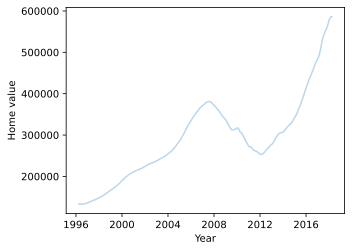

In [22]:
# Plot the time series
plt.figure(figsize=(5, 3.8))
plt.plot(df_ccity['time'], df_ccity['value'], alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Home value')
plt.show()

In [70]:
# Difference the time series
dft = df_ccity.set_index('time')

dft_diff = dft["value"].diff().dropna()
dft_diff

time
1996-05-01       0.0
1996-06-01       0.0
1996-07-01     100.0
1996-08-01     100.0
1996-09-01     300.0
               ...  
2017-12-01    7200.0
2018-01-01    9000.0
2018-02-01    5800.0
2018-03-01    2400.0
2018-04-01     100.0
Name: value, Length: 264, dtype: float64

In [71]:
dft = dft["value"]

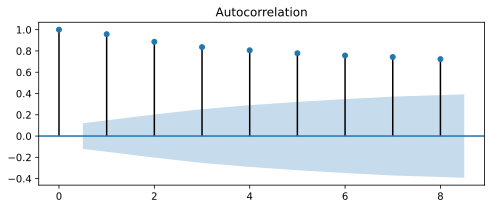

In [41]:
# Plot the ACF
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(dft_diff,ax=ax, lags=8);

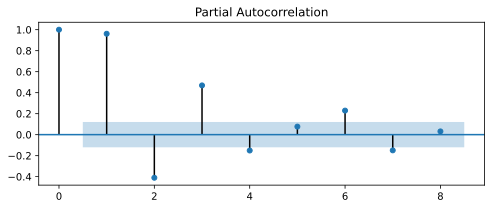

In [42]:
# Plot the PACF
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(dft_diff,ax=ax, lags=8);

In [43]:
# Import ARMA
from statsmodels.tsa.arima_model import ARMA

# Fit an ARMA(1,0) model
mod_arma = ARMA(dft_diff, order=(1,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                  264
Model:                     ARMA(1, 0)   Log Likelihood               -2149.877
Method:                       css-mle   S.D. of innovations            828.706
Date:                Sun, 08 Nov 2020   AIC                           4305.754
Time:                        11:21:41   BIC                           4316.482
Sample:                    05-01-1996   HQIC                          4310.065
                         - 04-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1479.8688   1090.990      1.356      0.175    -658.432    3618.170
ar.L1.value     0.9566      0.017     56.898      0.000       0.924       0.990
                                    Roots       

In [45]:
# Fit an ARMA(2,1) model
mod_arma = ARMA(dft_diff, order=(2,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                  264
Model:                     ARMA(2, 1)   Log Likelihood               -2107.455
Method:                       css-mle   S.D. of innovations            704.611
Date:                Sun, 08 Nov 2020   AIC                           4224.909
Time:                        11:40:52   BIC                           4242.789
Sample:                    05-01-1996   HQIC                          4232.094
                         - 04-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1556.4587    829.775      1.876      0.061     -69.870    3182.788
ar.L1.value     0.9953      0.088     11.300      0.000       0.823       1.168
ar.L2.value    -0.0738      0.087     -0.848    

In [47]:
# Fit an ARMA(2,2) model
mod_arma = ARMA(dft_diff, order=(2,2))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                  264
Model:                     ARMA(2, 2)   Log Likelihood               -2106.504
Method:                       css-mle   S.D. of innovations            702.136
Date:                Sun, 08 Nov 2020   AIC                           4225.009
Time:                        11:41:35   BIC                           4246.464
Sample:                    05-01-1996   HQIC                          4233.630
                         - 04-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1568.7576   1088.795      1.441      0.150    -565.241    3702.756
ar.L1.value     1.6357      0.152     10.743      0.000       1.337       1.934
ar.L2.value    -0.6483      0.144     -4.500    

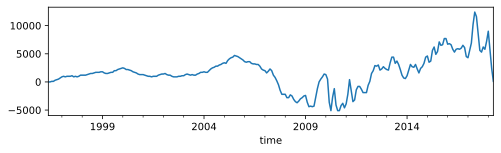

In [48]:
plt.figure(figsize=(8, 2))
dft_diff.plot()
# plt.xticks(rotation=45)
plt.show()

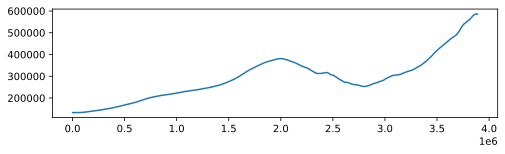

In [50]:

plt.figure(figsize=(8, 2))
df_ccity['value'].plot()
# plt.xticks(rotation=45)
plt.show()

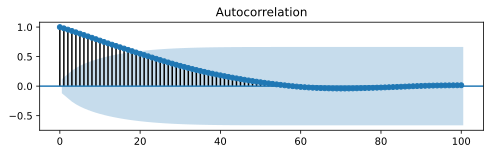

In [51]:
fig = plot_acf(df_ccity['value'], lags=100)
fig.set_size_inches(8, 2)
plt.show()

In [61]:
sellprice_d1 = pd.Series(np.diff(sellprice_not_na.values, n=1),
                           index=sellprice_not_na.index[1:])

# Step 5: ARIMA Modeling

In [73]:
def create_training_splits(data, log=False):
    
    train_size = int(len(data) * 0.8)
    
    train = data[:train_size]
    valid = data[train_size:]
    
    # Hardcoded
    test = dft[dft.index >= pd.to_datetime('2016')] 
    
    if log: 
        return np.log(train), np.log(valid), np.log(test)
    else: 
        return train, valid, test

In [74]:
train, valid, test = create_training_splits(dft)

In [75]:
logtrain, logvalid, logtest = create_training_splits(dft, log=True)

In [76]:
fulldata = dft

In [77]:
logfull = np.log(fulldata)

In [78]:
log_model_d1_D1 = pm.auto_arima(logtrain, start_p=1, start_q=1,
                                max_p=3, max_q=3, m=12,  # seasonal lag = 12
                                start_P=0, seasonal=True,
                                d=1, D=1, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-1749.031, Time=0.97 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1387.207, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1753.192, Time=0.85 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-1573.281, Time=0.92 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1688.879, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1762.758, Time=2.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-1767.566, Time=2.28 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-1768.148, Time=1.22 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-1717.973, Time=0.13 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-1772.317, Time=2.25 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-1785.812, Time=2.28 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-1399.765, Time=3.62 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=-1762.681, Time=1.58 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-1773.090, Time=2.14 sec
 ARIM

In [79]:
log_model_d1_D1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  212
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 911.349
Date:                            Sun, 08 Nov 2020   AIC                          -1810.697
Time:                                    14:13:45   BIC                          -1790.937
Sample:                                         0   HQIC                         -1802.700
                                            - 212                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.679e-05      0.000     -0.314      0.753      -0.000       0.000
ar.L1          0.3650      0.084      4.347      0.000       0.200       0.530
ar.L2          0.4876      0.078      6.231      0.000       0.334       0.641
ma.L1          0.8111      0.064     12.601      0.000       0.685       0.937
ma.S.L12      -0.7197      0.044    -16.299      0.000      -0.806      -0.633
sigma2      5.816e-06   3.53e-07     16.489      0.000    5.12e-06    6.51e-06
===================================================================================
Ljung-Box (Q):                      143.74   Jarque-Bera (JB):               555.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              25.62   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

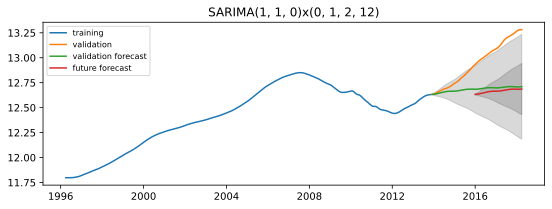

In [80]:
fc1, conf1 = log_model_d1_D1.predict(len(logvalid), return_conf_int=True, alpha=0.05)
fc2, conf2 = log_model_d1_D1.predict(len(logtest), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=logvalid.index)
fc_series2 = pd.Series(fc2, index=logtest.index)

lower_series1 = pd.Series(conf1[:, 0], index=logvalid.index)
upper_series1 = pd.Series(conf1[:, 1], index=logvalid.index)
lower_series2 = pd.Series(conf2[:, 0], index=logtest.index)
upper_series2 = pd.Series(conf2[:, 1], index=logtest.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(logtrain, label='training')
plt.plot(logvalid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA(1, 1, 0)x(0, 1, 2, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [81]:
mse = ((fc_series1 - logvalid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

0.32


In [82]:
mse = ((np.exp(fc_series1) - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

134343.62


In [83]:
log_model_d1_D1_full = pm.auto_arima(logfull, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-2222.942, Time=0.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1764.417, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2138.536, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-2002.534, Time=0.90 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-2156.542, Time=0.33 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-2222.553, Time=0.86 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-2230.481, Time=3.00 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-2229.896, Time=1.87 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-1992.531, Time=2.47 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-2190.053, Time=2.20 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=-2282.535, Time=5.91 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=-2256.935, Time=1.78 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=-2271.597, Time=5.16 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=-2281.760, Time=2.10 sec
 ARIM

In [84]:
log_model_d1_D1_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  265
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                1154.189
Date:                                 Sun, 08 Nov 2020   AIC                          -2294.377
Time:                                         14:18:48   BIC                          -2269.671
Sample:                                              0   HQIC                         -2284.436
                                                 - 265                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.101e-05      0.000      0.204      0.839      -0.000       0.000
ar.L1          0.4974      0.082      6.081      0.000       0.337       0.658
ar.L2          0.3813      0.082      4.671      0.000       0.221       0.541
ma.L1          0.7800      0.057     13.571      0.000       0.667       0.893
ma.S.L12      -0.9173      0.035    -26.328      0.000      -0.986      -0.849
ma.S.L24       0.2506      0.044      5.752      0.000       0.165       0.336
sigma2      5.826e-06   2.91e-07     20.016      0.000    5.26e-06     6.4e-06
===================================================================================
Ljung-Box (Q):                      109.89   Jarque-Bera (JB):               316.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.59   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

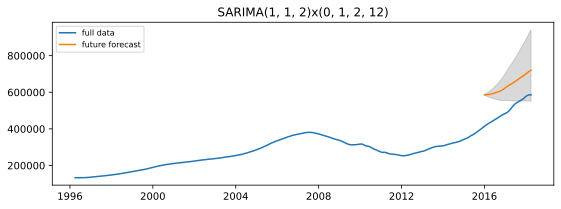

In [85]:
fc1, conf1 = log_model_d1_D1_full.predict(len(logtest), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(np.exp(fc1), index=logtest.index)

lower_series1 = np.exp(pd.Series(conf1[:, 0], index=logtest.index))
upper_series1 = np.exp(pd.Series(conf1[:, 1], index=logtest.index))


# Plot
plt.figure(figsize=(9, 3))
plt.plot(np.exp(logfull), label='full data')
plt.plot(fc_series1, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)

plt.title('SARIMA(1, 1, 2)x(0, 1, 2, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Stash box:

In [ ]:

, parse_dates=['Date']

In [87]:
df_origin

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400
